# Beer Advocate Case

## About the dataset

This dataset consists of beer reviews from Beeradvocate. The data span a period of more than 10 years, including all ~1.5 million reviews up to November 2011. Each review includes ratings in terms of five "aspects": appearance, aroma, palate, taste, and overall impression. Reviews include product and user information, followed by each of these five ratings, and a plaintext review. We also have reviews from ratebeer.

https://data.world/socialmediadata/beeradvocate

## About the task

The task is about to provide an answer for the following questions:

- Which brewery produces the strongest beers by abv ?
- If you had to pick 3 beers to recommend to someone, how would you approach the problem ?
- What are the factors that impacts the quality of beer the most ?
- I enjoy a beer which aroma and appearance matches the beer style. What beer should I buy ?

## Approach

To tackle this task, I have decided to prepare the analysis in Jupyter Notebooks using Python and well-known Python libraries. Although Jupyter Notebooks have their opponents, I believe that thanks to their interactive computing and data visualization capabilities they fit pretty well to ad-hoc analyses such as this one.

## Setup

In this analysis I will be using Python 3.8 and the following libraries:
- pandas - for using DataFrame as a primary data structure for the dataset
- matplotlib and seaborn - for data visualization
- numpy - for efficient matrix operations
- additional libraries, when necessary

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from datetime import datetime

## Data exploration

To start with, I would like to explore basic characteristics of the dataset to have a flavour of the data that will be used throughout this task.

In [2]:
def load_data(filename):
    # Load data into pandas DataFrame
    df = pd.read_csv(filename)
    
    # Reorder columns
    df = df[[
        'brewery_id',
        'brewery_name',
        'beer_beerid',
        'beer_name',
        'beer_style',
        'beer_abv',
        'review_time',
        'review_profilename',
        'review_appearance',
        'review_aroma',
        'review_palate',
        'review_taste',
        'review_overall'
    ]]
    
    # Convert str columns to numeric
    numeric_columns = [
        "beer_abv",
        "review_appearance",
        "review_aroma",
        "review_palate",
        "review_taste",
        "review_overall"
    ]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)
    
    return df    

In [3]:
df = load_data('data/beer_reviews.csv')
df.head()

,brewery_id,brewery_name,beer_beerid,beer_name,beer_style,beer_abv,review_time,review_profilename,review_appearance,review_aroma,review_palate,review_taste,review_overall
0,10325,Vecchio Birraio,47986,Sausa Weizen,Hefeweizen,5.0,1234817823,stcules,2.5,2.0,1.5,1.5,1.5
1,10325,Vecchio Birraio,48213,Red Moon,English Strong Ale,6.2,1235915097,stcules,3.0,2.5,3.0,3.0,3.0
2,10325,Vecchio Birraio,48215,Black Horse Black Beer,Foreign / Export Stout,6.5,1235916604,stcules,3.0,2.5,3.0,3.0,3.0
3,10325,Vecchio Birraio,47969,Sausa Pils,German Pilsener,5.0,1234725145,stcules,3.5,3.0,2.5,3.0,3.0
4,1075,Caldera Brewing Company,64883,Cauldron DIPA,American Double / Imperial IPA,7.7,1293735206,johnmichaelsen,4.0,4.5,4.0,4.5,4.0


Now, I would like to explore how many unique items we have in most important columns. For example, we can see, that the number of distinct beers is lower than the number of distinct beer names and therefore it makes sense to use `beer_beerid` column as a unique identifier for a beer, as different beers can be named the same from different breweries.

In [4]:
unique_breweries = len(df['brewery_id'].unique())
unique_beers = len(df['beer_beerid'].unique())
unique_beer_names = len(df['beer_name'].unique())
unique_beer_styles = len(df['beer_style'].unique())
unique_reviews = len(df)
unique_reviewers = len(df['review_profilename'].unique())

print(f"Unique breweries: {unique_breweries}")
print(f"Unique beers: {unique_beers}")
print(f"Unique beer names: {unique_beer_names}")
print(f"Unique beer styles: {unique_beer_styles}")
print(f"Unique reviews: {unique_reviews}")
print(f"Unique reviewers: {unique_reviewers}")

Unique breweries: 5840
Unique beers: 66055
Unique beer names: 56857
Unique beer styles: 104
Unique reviews: 1586614
Unique reviewers: 33388


Before going to explore data in more detail, I would like to check if there are missing values in our dataset. It seems that there are some:
- missing brewery names (15), but that's not an issue
- missing beer abvs (67,785) which accounts for a high percentage of a total - that's the issue which will need to be addressed when answering Q1
- missing review profilenames (348) - the number is not very significant, but again, this will need to be addressed when answering Q2

In [5]:
def check_for_nulls(df):
    for column in list(df):
        null_count = df[column].isnull().sum()
        null_ratio = null_count / len(df)
        print(f"{column.ljust(18)} \t {null_count} \t ({null_ratio*100:.2f}%)")

In [6]:
check_for_nulls(df)

brewery_id         	 0 	 (0.00%)
brewery_name       	 15 	 (0.00%)
beer_beerid        	 0 	 (0.00%)
beer_name          	 0 	 (0.00%)
beer_style         	 0 	 (0.00%)
beer_abv           	 67785 	 (4.27%)
review_time        	 0 	 (0.00%)
review_profilename 	 348 	 (0.02%)
review_appearance  	 0 	 (0.00%)
review_aroma       	 0 	 (0.00%)
review_palate      	 0 	 (0.00%)
review_taste       	 0 	 (0.00%)
review_overall     	 0 	 (0.00%)


Now I would like to explore specific fields in a bit more detail.

**Breweries (`brewery_id`)**

I would like to see how many beers breweries produce (to be specific, those that are reviewed on BeerAdvocate).

Data shows that the distribution of beers by brewery is highly skewed (even if placed on the log axis). While most most breweries produce fewer beers (the "middle" brewery produces just 5 bear judging by the median), there are breweries that produce really a lot (with the record brewery producing 855 beers).

In [7]:
beers_by_brewery = df.groupby('brewery_id').beer_beerid.nunique()
beers_by_brewery.name = "Beers by brewery"

assert beers_by_brewery.sum() == unique_beers

<AxesSubplot:xlabel='Beers by brewery', ylabel='Count'>

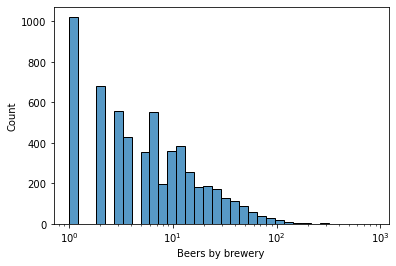

In [8]:
sns.histplot(data=beers_by_brewery,
             log_scale=True)

In [9]:
print(f"The record brewery produces {beers_by_brewery.max()} beers that are rated on BeerAdvocate")

The record brewery produces 855 beers that are rated on BeerAdvocate


In [10]:
beers_by_brewery.mean()

11.310787671232877

In [11]:
beers_by_brewery.median()

5.0

**Beers (`beer_beerid`)**

I would like to see how many reviews beers have on BeerAdvocate.

Again, there is a similar pattern here as for beers by brewery. The distribution of reviews by beer is highly skewed with the long tail on the right hand side. Most beers are rated just once, but the record beer was rated more than 3 thousand times.

In [12]:
reviews_by_beer = df.groupby('beer_beerid').beer_beerid.count()  # each row represents a separate review
reviews_by_beer.name = "Reviews by beer"

assert reviews_by_beer.sum() == df.shape[0]

<AxesSubplot:xlabel='Reviews by beer', ylabel='Count'>

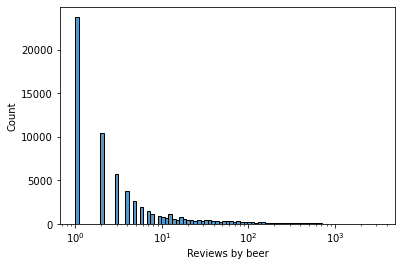

In [13]:
sns.histplot(data=reviews_by_beer,
             log_scale=True)

In [14]:
print(f"The record beer have {reviews_by_beer.max()} reviews on BeerAdvocate")
print(f"Mean: {reviews_by_beer.mean()}")
print(f"Median: {reviews_by_beer.median()}")

The record beer have 3290 reviews on BeerAdvocate
Mean: 24.019589735826205
Median: 2.0


**Beer styles (`beer_style`)**

To end the exploration part, I would like to check if the similar pattern can be found for reviews by bear style.

Again, when looking at the standard axis, the distribution looks skewed, but when placed on the log axis, the data looks more like from a normal distribution. What's also interesting is that 50% of all reviews are added to just the top 18 beer styles (by the number of reviews). It seems that some beer styles are much more popular than others.

In [15]:
reviews_by_beer_style = df.groupby('beer_style').beer_beerid.count()  # each row represents a separate review
reviews_by_beer_style.name = "Reviews by beer style"

assert reviews_by_beer_style.sum() == df.shape[0]

<AxesSubplot:title={'center':'Log axis'}, xlabel='Reviews by beer style', ylabel='Count'>

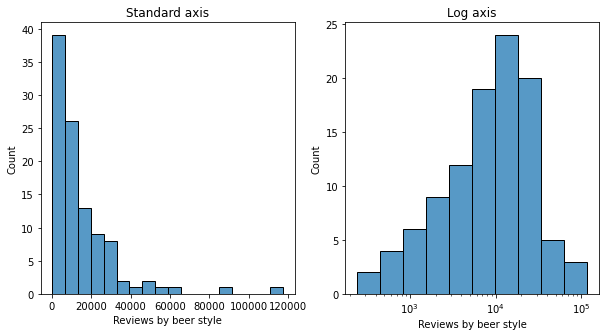

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('Standard axis')
axes[1].set_title('Log axis')
sns.histplot(ax=axes[0],
             data=reviews_by_beer_style,
             log_scale=False)
sns.histplot(ax=axes[1],
             data=reviews_by_beer_style,
             log_scale=True)

In [17]:
reviews_by_beer_style_df = reviews_by_beer_style.sort_values(ascending=False).to_frame()
reviews_by_beer_style_df['ratio'] = reviews_by_beer_style_df["Reviews by beer style"] / df.shape[0]
reviews_by_beer_style_df['cum_ratio'] = reviews_by_beer_style_df['ratio'].cumsum()
reviews_by_beer_style_df.head(20)

,Reviews by beer style,ratio,cum_ratio
beer_style,,,
American IPA,117586,0.074111,0.074111
American Double / Imperial IPA,85977,0.054189,0.128300
American Pale Ale (APA),63469,0.040003,0.168303
Russian Imperial Stout,54129,0.034116,0.202419
American Double / Imperial Stout,50705,0.031958,0.234377
American Porter,50477,0.031814,0.266191
American Amber / Red Ale,45751,0.028836,0.295027
Belgian Strong Dark Ale,37743,0.023788,0.318815
Fruit / Vegetable Beer,33861,0.021342,0.340157


## Q1: Which brewery produces the strongest beers by abv ?

There is no simple answer to this question because it depends on what we mean by brewery producing strongest beers. To answer this question, I'll try to touch upon the following points:
- Which brewery produces the strongest beer?
- Which brewery produces the strongest beers based on some kind of average (mean and median)?

The reason I want to include the single strongest beer is that if someone is looking for the strongest beer, all they really care about is just the strongest beer and not beers produced by the "strongest on average" brewery.

In [18]:
def prepare_data_q1(df):
    # Remove reviews for beers without abv data
    df = df.loc[df['beer_abv'].notnull()]
    
    # Replace nulls in brewery_name with empty string not to lose any data
    df.brewery_name = df.brewery_name.fillna('')

    
    return df

assert prepare_data_q1(df).shape[0] < df.shape[0]

/home/andrzej/anaconda3/envs/dev/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
df_q1 = prepare_data_q1(df)

**Breweries producing the strongest beers**

The strongest beer rated on BeerAdvocate has been brewed by Schorschbräu (by a far margin). Actually, this brewery appears twice in the TOP 5 of the strongest beers, so it seems reasonable to claim the it produces the strongest beers. However, I will explore one more way of answering this question.

In [20]:
df_q1.groupby(['beer_beerid', 'beer_name', 'brewery_id', 'brewery_name']).beer_abv.max().sort_values(ascending=False)

beer_beerid  beer_name                      brewery_id  brewery_name                            
73368        Schorschbräu Schorschbock 57%  6513        Schorschbräu                                57.70
57856        Schorschbräu Schorschbock 43%  6513        Schorschbräu                                43.00
57015        Sink The Bismarck!             16315       BrewDog                                     41.00
55712        Schorschbräu Schorschbock 40%  6513        Schorschbräu                                39.44
70633        Black Damnation VI - Messy     15237       De Struise Brouwers                         39.00
                                                                                                    ...  
26396        Xan Wellness                   252         Bayerische Staatsbrauerei Weihenstephan      0.05
5872         Bavaria Malt                   498         Bavaria Brouwerij N.V.                       0.05
11198        Genesee NA                     302        

**Breweries producing the strongest beers on average**

By looking at the arithmetic mean, Schorschbräu is still the leader. However, when looking at the median, the leadership has changed and now Shoes Brewery is the leader. This might be due to the fact that Schorschbräu is producing a few very strong beers but also quite a few "standard" beers and that's its mean is biased upwards compared to its mean.


*Average = Mean*

In [21]:
df_q1.groupby(['brewery_id', 'brewery_name']).beer_abv.mean().sort_values(ascending=False)

brewery_id  brewery_name                       
6513        Schorschbräu                           19.228824
14060       Shoes Brewery                          15.200000
2873        Rome Brewing Company                   13.840000
736         Hurlimann Brewery                      13.750000
10038       Alt-Oberurseler Brauhaus               13.200000
                                                     ...    
2349        Cerveceria Vegana, S.A.                 2.260870
23305       Moskovskaya Pivovarennaya Kompaniya     2.150000
19144       Fentimans Ltd.                          1.375000
24676       Borodino ZAO                            0.966667
16991       All Stars Bakery                        0.500000
Name: beer_abv, Length: 5232, dtype: float64

*Average = Median*

In [22]:
df_q1.groupby(['brewery_id', 'brewery_name']).beer_abv.median().sort_values(ascending=False)

brewery_id  brewery_name              
14060       Shoes Brewery                 15.2
1614        River City Brewing Company    14.0
736         Hurlimann Brewery             14.0
285         Brauerei Schloss Eggenberg    14.0
2097        Kuhnhenn Brewing Company      13.5
                                          ... 
24676       Borodino ZAO                   1.2
2349        Cerveceria Vegana, S.A.        0.5
19144       Fentimans Ltd.                 0.5
16991       All Stars Bakery               0.5
10526       Israel Beer Breweries Ltd.     0.5
Name: beer_abv, Length: 5232, dtype: float64

**Conclusion**

There is no simple answer, but the safe assumption would be to point Schorschbräu as the brewery producing the strongest beers. However, much more can be done, depending on the what we are interested the most, for example we can:
- calculate the weighted average of beer_abv, weighted by the number of reviews which can serve as a proxy for beer popularity (after all, we don't want to give the same weight to the almost unknown beer as to the very popular beer from the same brewery which is available all over the country and got many reviews)
- give more weight to stronger beers and decrease the importance of "standard" beers 
- focus on just the part of the distribution for each brewery (e.g. compare beers from just the top 10th or 25th percentile for each brewery)

## Q2: If you had to pick 3 beers to recommend to someone, how would you approach the problem?

In [23]:
def prepare_data_for_q2(df):
    # Exclude data with nulls in review_profilename
    df = df.loc[df['review_profilename'].notnull()]
    
    # Leave only columns that we need
    columns = [
        "review_profilename",  # reviewer
        "beer_beerid",  # beer
        "beer_style",   # beer style
        "beer_name",    # beer name for decoding predictions
        "review_overall",  # rating
        "review_time",  # timestamp
    ]
    
    return df[columns]

assert len(df) - len(prepare_data_for_q2(df)) == 348  # There are 348 nulls in this column in our dataframe

In [24]:
df_q2 = prepare_data_for_q2(df)

This sounds like a recommendation problem and is best served with a recommender system.

However, first I would like to split this questions into two parts:
- recommending beer to someone I don't know anything about (their preferences about beers, in particular)
- recommending beer to someone I know what they like (e.g. based on the reviews they have already posted on BeerAdvocate)

**Case 1**

If the first point is the case, we need to make a guess as we don't know what that person likes. However, we can make a bit more informed guess by taking into account the reviews data we have in our disposal. Therefore, I would like to propose a simple recommender system in that case which would recommend the top rated beers.

However, to overcome the problem of recommeding a pure 5-star beer having just 1 review, I would like to normalize the review scores first in the following way:
- divide overall review scores by 5 to make sure they lie in [0, 1] range
- assume the prior beta distribution with prior alpha of 3 and prior beta of 2
- include the overall review score (after diving by 5) and the number of reviews to calculate the posterior distribution value
- multiply the result by 5 to revert back to the original scale. However, the high scores with few reviews will be pushed down as there is quite a bit of uncertainty connected with them, whereas scores with many reviews will be left relatively untouched.

In [25]:
beer_review_scores = df_q2.groupby(['beer_beerid', 'beer_name']).review_overall.mean()
beer_review_scores.name = 'average_review_overall'
beer_review_count = df_q2.groupby(['beer_beerid', 'beer_name']).beer_beerid.count()
beer_review_count.name = 'count_of_reviews'
beer_reviews = pd.concat([beer_review_scores, beer_review_count], axis=1)
beer_reviews.sort_values(by=['average_review_overall'], ascending=False)  # Before normalization

,,average_review_overall,count_of_reviews
beer_beerid,beer_name,,
45046,Oak Aged IPA,5.0,1
36467,"Midlands Mild ""A Spoonful Weighs A Ton""",5.0,2
18688,Traffic Jam Slam Dunkel,5.0,1
10464,Pots Ale,5.0,1
66421,Bennie's Brew,5.0,2
...,...,...,...
14093,Gold Coast Queensland Bitter,1.0,1
14096,Sunshine Coast Bitter,1.0,1
38127,Landskron Pupen-Schultzer Schwarzes,1.0,1


In [26]:
alpha = 3
beta = 2
divider = 5

beer_reviews['normalized_review'] = (alpha + \
                                   beer_reviews.count_of_reviews * (beer_reviews.average_review_overall / divider)) \
                                  / (alpha + beta + beer_reviews.count_of_reviews) * divider

beer_reviews = beer_reviews.sort_values(by=['normalized_review'], ascending=False)
beer_reviews

,,average_review_overall,count_of_reviews,normalized_review
beer_beerid,beer_name,,,
44910,Dirty Horse,4.820513,39,4.613636
1545,Trappist Westvleteren 12,4.617925,1272,4.611590
16814,Heady Topper,4.625800,469,4.608650
68548,Armand'4 Oude Geuze Lente (Spring),4.730769,65,4.607143
63649,Rare D.O.S.,4.848485,33,4.605263
...,...,...,...,...
43360,Raspberry Ale,1.233333,15,1.675000
32690,Pit Bull,1.153846,13,1.666667
2373,Dixie White Moose,1.250000,16,1.666667


**Conclusion - Case 1**

The three beers I would recommend to someone I don't know anything about based on the above methodology would be:
- Dirty Horse
- Trappist Westvleteren 12
- Heady Topper

In [27]:
beer_reviews.head(3)

,,average_review_overall,count_of_reviews,normalized_review
beer_beerid,beer_name,,,
44910,Dirty Horse,4.820513,39,4.613636
1545,Trappist Westvleteren 12,4.617925,1272,4.611590
16814,Heady Topper,4.625800,469,4.608650


**Case 2**

If we have some information about a given person's preferences, we can make our recommendation better by using this information to make the predictions.

In this section I would like to propose a model which would use the information from almost all the reviews (excluding only those without the user data) in our dataset to make recommendations to the user about new beers to try based on the previous history of reviews.

I would like to use the approach based on Singular Value Decomposition (SVD) popularized by Simon Funk (a relatively simple, yet very powerful methodology). This is the type of Matrix Factorization which is a very popular technique used in recommender systems.

During the task, I based on the implementation of Funk's SVD as proposed by Kim Falk: https://github.com/practical-recommender-systems/moviegeek/blob/master/builder/matrix_factorization_calculator.py. However, compared with his implementation, I made the following updates to the MatrixFactorization class:
- merged the training class with the recommender class
- added validation data during training (account for approx. 12% of the full dataset)
- set up a "naive" early stopping based on the validation RMSE
- made a few other minor updates so that the class fits our dataset

The idea of SVD is to identify hidden features of the ratinigs data that would be used for making predictions and that would otherwise go unnoticed. Also, in this implementation there are included two bias factors:
- user bias (that every reviewer has a different taste and a different notion of what is very good and what is just OK)
- item bias (that every beer is different and some are better than others)

In [28]:
from matrix_factorization import MatrixFactorization, load_all_ratings

# Load review data
loaded_ratings = load_all_ratings(prepare_data_for_q2(df), min_ratings=1)

# Initialize MatrixFactorization class
MF = MatrixFactorization(save_path='./models/funkSVD/{}/'.format(datetime.now()), max_iterations=40)

# Train the model using k=20 features
MF.train(loaded_ratings, k=20)

user_factors are (33387, 20)
training matrix factorization at 2021-05-27 17:46:18.611235
159305
1426961
epoch in 0:00:41.532637, f=0, i=1 err=0.6445853552502081 valid_err=0.7031334016144174
epoch in 0:00:38.112143, f=0, i=2 err=0.6351882785163423 valid_err=0.6965097489899954
epoch in 0:00:35.953030, f=0, i=3 err=0.6301227826366722 valid_err=0.6934777824833154
epoch in 0:00:37.410083, f=0, i=4 err=0.6266582949841039 valid_err=0.6916604169371098
epoch in 0:00:37.836664, f=0, i=5 err=0.6239923260348548 valid_err=0.6904391137492298


KeyboardInterrupt: 

To recommend the beers for the user based on the learned model, we can use the recommend_items() method on the MatrixFactorization class which:
- computes all the predicted review scores a given user would give to beers they haven't tried yet
- orders those predictions in descending order and returns the top 3 of them

In [29]:
reviewer = 'inman66'

MF.recommend_items(reviewer, loaded_ratings)  # returns beer ids

[(36316, {'prediction': 4.653715500835311}),
 (56082, {'prediction': 4.6395148698885045}),
 (41928, {'prediction': 4.620811368222843})]

**Remark!**

This is by no means the complete model. Due to the time constraint, the training has been running only for a limited amount of time and to explore fully this technique, the following things should be considered:
- training the model for longer
- optimizing the model's hyperparameters
- limiting the number of reviewers to include in the model (to make the user-item matrix less sparse and the training faster)
- including temporal effects (that the user's taste may change over time, and that the brewery may change the recipe for a given beer)

## Q3: What are the factors that impacts the quality of beer the most ?

In our dataset, the reviews are composed of the overall score, plus the following component parts:
- appearance
- aroma
- palate
- taste

To answer this question, I would like to propose a simple regression model where the overall score (quality) would be the predicted variable and the four component parts being the predictors. After estimation of the model, I would take a look at the feature importance to answer the question of which of those four components are the most important.

Before, the linear regression is estimated, all features are standardized so that they have a zero mean and the resulting distribution has unit variance.

In [30]:
predictors = [
    "review_appearance",
    "review_aroma",
    "review_palate",
    "review_taste",
]

predicted = ["review_overall"]

df_q3 = df[predictors + predicted]
df_q3.head()

,review_appearance,review_aroma,review_palate,review_taste,review_overall
0,2.5,2.0,1.5,1.5,1.5
1,3.0,2.5,3.0,3.0,3.0
2,3.0,2.5,3.0,3.0,3.0
3,3.5,3.0,2.5,3.0,3.0
4,4.0,4.5,4.0,4.5,4.0


In [31]:
scaler = StandardScaler()
scaler.fit(df_q3)
X_y = scaler.transform(df_q3)
X_y

array([[-2.1776625 , -2.48795155, -3.28883272, -3.13245406, -3.21331018],
       [-1.36609615, -1.7712254 , -1.09012252, -1.08318801, -1.13177402],
       [-1.36609615, -1.7712254 , -1.09012252, -1.08318801, -1.13177402],
       ...,
       [-1.36609615, -0.33777308, -0.35721912,  0.28298936,  0.94976213],
       [ 1.06860288,  1.09567923,  1.10858768,  0.96607804,  0.25591675],
       [ 1.06860288,  1.09567923,  1.10858768,  0.96607804,  1.64360752]])

In [32]:
X = X_y[:, :4]
y = X_y[:, 4]

In [33]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [34]:
print(f"R2: {reg.score(X, y):.4f}")

R2: 0.6581


Feature: 0 (review_appearance), Score: 0.0307
Feature: 1 (review_aroma), Score: 0.0463
Feature: 2 (review_palate), Score: 0.2447
Feature: 3 (review_taste), Score: 0.5602


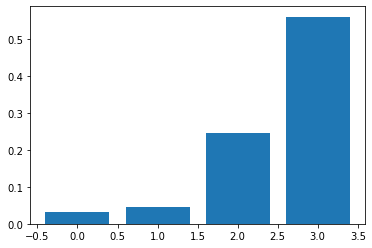

In [35]:
importance = reg.coef_

for i, v in enumerate(importance):
    print(f'Feature: {i:0d} ({predictors[i]}), Score: {v:.4f}')

plt.bar([x for x in range(len(importance))], importance)
plt.show()

**Conclusion**

Based on the calculated feature importances, it seems clear that taste has the highest impact on the overall score (quality), and palate is the next. This is true, but we need to take into account there may be correlations between those four components as they are intrisically linked to each other. This may have an impact on the importance and a detailed analysis should be make to confirm these findings. We may also include the reviewer bias into account.

## Q4: I enjoy a beer which aroma and appearance matches the beer style. What beer should I buy?

I believe that a beer which aroma and appearance matches the beer style is the beer where the review scores both in aroma and appearance are highest. Otherwise, if aroma and appearance didn't match the beer style, the reviewer wouldn't give 5 stars to that beer. After all, they assess how good the beer is (and indirectly, how close the beer is to the perceived "ideal", i.e. the beer that matches its style perfectly). Therefore, the higher the score is, the closer are the beer characteristics to the beer style.

To calculate the beer for which the aroma and appearance are the highest, I would you a two-step approach:
- average aroma and appearance scores using the arithmetic mean
- average that average score per bear
- normalize scores using the approach from Q2 (using prior/posterior beta distributions)

In [36]:
df_q4 = df.copy()
df_q4['aroma_appearance_score'] = (df['review_appearance'] + df['review_aroma']) / 2

beer_review_scores_q4 = df_q4.groupby(['beer_beerid', 'beer_name']).aroma_appearance_score.mean()
beer_review_scores_q4.name = 'avg_aroma_appearance_score'

beer_review_count_q4 = df_q4.groupby(['beer_beerid', 'beer_name']).beer_beerid.count()
beer_review_count_q4.name = 'count_of_reviews'

beer_reviews_q4 = pd.concat([beer_review_scores_q4, beer_review_count_q4], axis=1)
beer_reviews_q4.sort_values(by=['avg_aroma_appearance_score'], ascending=False)  # Before normalization

,,avg_aroma_appearance_score,count_of_reviews
beer_beerid,beer_name,,
20394,Alternator Double Malt,5.0,1
39926,Bottleworks Imagination Series VIII Laphroaig Barrel Aged Scotch Ale,5.0,1
27766,Grand Cru,5.0,1
29423,Old Gander Barley Wine,5.0,1
1131,Bourbon Barrel Stout,5.0,1
...,...,...,...
11350,Scorcher Summer Ale,1.0,1
20858,Berliner Bürgerbräu Königsschlösser,1.0,1
32505,Wasabi Dry,1.0,1


In [38]:
alpha = 3
beta = 2
divider = 5

beer_reviews_q4['normalized_aroma_appearance_score'] = (alpha + \
                                   beer_reviews_q4.count_of_reviews * (beer_reviews_q4.avg_aroma_appearance_score / divider)) \
                                  / (alpha + beta + beer_reviews_q4.count_of_reviews) * divider

beer_reviews_q4 = beer_reviews_q4.sort_values(by=['normalized_aroma_appearance_score'], ascending=False)
beer_reviews_q4

,,avg_aroma_appearance_score,count_of_reviews,normalized_aroma_appearance_score
beer_beerid,beer_name,,,
21690,Pliny The Younger,4.603279,610,4.590244
36316,Cantillon Blåbær Lambik,4.586538,156,4.537267
42349,Vanilla Bean Aged Dark Lord,4.583882,152,4.533439
34420,The Abyss,4.518414,1412,4.513056
1545,Trappist Westvleteren 12,4.518671,1272,4.512725
...,...,...,...,...
14697,Stite Light Lager,1.222222,9,1.857143
37424,Bud Light Chelada,1.802632,114,1.852941
233,Corona Light,1.777778,342,1.795389


**Conclusion**

Based on the above methodology and data, I would recommend the following 3 beers:
- Pliny The Younger
- Cantillon Blåbær Lambik
- Vanilla Bean Aged Dark Lord

In [39]:
beer_reviews_q4.head(3)

,,avg_aroma_appearance_score,count_of_reviews,normalized_aroma_appearance_score
beer_beerid,beer_name,,,
21690,Pliny The Younger,4.603279,610,4.590244
36316,Cantillon Blåbær Lambik,4.586538,156,4.537267
42349,Vanilla Bean Aged Dark Lord,4.583882,152,4.533439
